In [503]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

from sklearn.linear_model import LinearRegression

In [504]:
counts_raw = pd.read_csv("FremontBridge.csv", index_col='Date', parse_dates=True)
weather = pd.read_csv("BicycleWeather.csv", index_col='DATE', parse_dates=True)

In [505]:
print(counts_raw.shape)
print(weather.shape)
#print(counts_raw.tail())
print(weather.head())

(59832, 2)
(1340, 25)
                      STATION                                STATION_NAME  \
DATE                                                                        
2012-01-01  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-02  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-03  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-04  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   
2012-01-05  GHCND:USW00024233  SEATTLE TACOMA INTERNATIONAL AIRPORT WA US   

            PRCP  SNWD  SNOW  TMAX  TMIN  AWND  WDF2  WDF5  ...  WT17  WT05  \
DATE                                                        ...               
2012-01-01     0     0     0   128    50    47   100    90  ... -9999 -9999   
2012-01-02   109     0     0   106    28    45   180   200  ... -9999 -9999   
2012-01-03     8     0     0   117    72    23   180   170  ... -9999 -9999   
2012-01-04   203     0     0   122    56   

In [506]:
daily_raw = counts_raw.resample('d').sum()
daily_raw['Total'] = daily_raw.sum(axis=1)
daily_raw = daily_raw[['Total']] # remove other columns

print(daily_raw.shape)
print(daily_raw.head())

(2493, 1)
             Total
Date              
2012-10-03  3521.0
2012-10-04  3475.0
2012-10-05  3148.0
2012-10-06  2006.0
2012-10-07  2142.0


In [507]:
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
for i in range(7):
    daily_raw[days[i]] = (daily_raw.index.dayofweek == i).astype(float)

In [508]:
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays('2012', '2016')
daily_raw = daily_raw.join(pd.Series(1, index=holidays, name='holiday'))
daily_raw['holiday'].fillna(0, inplace=True)

print("done")

done


(8, 17)

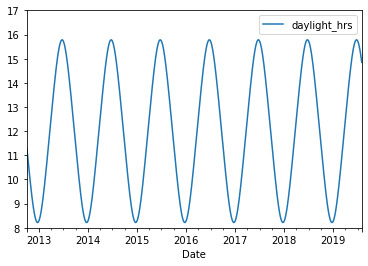

In [509]:
def hours_of_daylight(date, axis=23.44, latitude=47.61):
    """Compute the hours of daylight for the given date"""
    days = (date - pd.datetime(2000, 12, 21)).days
    m = (1. - np.tan(np.radians(latitude))
         * np.tan(np.radians(axis) * np.cos(days * 2 * np.pi / 365.25)))
    return 24. * np.degrees(np.arccos(1 - np.clip(m, 0, 2))) / 180.

daily_raw['daylight_hrs'] = list(map(hours_of_daylight, daily_raw.index))
daily_raw[['daylight_hrs']].plot()
plt.ylim(8, 17)

In [510]:
# temperatures are in 1/10 deg C; convert to C
weather['TMIN'] /= 10
weather['TMAX'] /= 10
weather['Temp (C)'] = 0.5 * (weather['TMIN'] + weather['TMAX'])

# precip is in 1/10 mm; convert to inches
weather['PRCP'] /= 254
weather['dry day'] = (weather['PRCP'] == 0).astype(int)

daily_raw = daily_raw.join(weather[['PRCP', 'Temp (C)', 'dry day']])

In [511]:
daily_raw['annual'] = (daily_raw.index - daily_raw.index[0]).days / 365.

In [512]:
print(daily_raw.head())
print(daily_raw.shape)
daily_test = daily_raw

             Total  Mon  Tue  Wed  Thu  Fri  Sat  Sun  holiday  daylight_hrs  \
Date                                                                           
2012-10-03  3521.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0      0.0     11.277359   
2012-10-04  3475.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0      0.0     11.219142   
2012-10-05  3148.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0      0.0     11.161038   
2012-10-06  2006.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0      0.0     11.103056   
2012-10-07  2142.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0      0.0     11.045208   

            PRCP  Temp (C)  dry day    annual  
Date                                           
2012-10-03   0.0     13.35      1.0  0.000000  
2012-10-04   0.0     13.60      1.0  0.002740  
2012-10-05   0.0     15.30      1.0  0.005479  
2012-10-06   0.0     15.85      1.0  0.008219  
2012-10-07   0.0     15.85      1.0  0.010959  
(2493, 14)


In [513]:
m = 0
print(daily_test.shape)
for i,j,k in zip(daily_test['PRCP'], daily_test['Temp (C)'], daily_test['dry day']):
    if math.isnan(i) and math.isnan(j) and math.isnan(k):
        m+=1
        
print(m)

(2493, 14)
1429


In [514]:
m=0
for i,j in zip(daily_test['PRCP'], daily_test['dry day']):
    if i!=0 and j==0:
        m+=1
        
print(m)

442


In [515]:
daily_raw.dropna(axis=0, how='any', inplace=True)
print(daily_raw.shape)

daily_raw['Temp (C)']=daily_raw['Temp (C)']**2

(1064, 14)


In [516]:
daily_holiday = daily_raw[daily_raw['holiday']==1]

daily_normal = daily_raw[daily_raw['holiday']==0]

daily_normal.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual
Date,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,178.2225,1.0,0.000000
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,184.9600,1.0,0.002740
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,234.0900,1.0,0.005479
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,251.2225,1.0,0.008219
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,251.2225,1.0,0.010959


In [517]:
column_names_holiday = ['daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily_holiday[column_names_holiday]
y = daily_holiday['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily_holiday['predicted'] = model.predict(X)

daily_holiday.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-08,3537.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,10.987503,0.000000,208.8025,1.0,0.013699,2025.921988
2012-11-12,1631.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,9.157323,0.141732,89.3025,0.0,0.109589,1427.342871
2012-11-22,554.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,8.760840,0.000000,34.2225,1.0,0.136986,1430.253554
2012-12-25,98.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8.229824,0.531496,17.6400,0.0,0.227397,431.350065
2013-01-01,678.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,8.300906,0.000000,1.2100,1.0,0.246575,1306.762340


In [518]:
column_names_normal = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily_normal[column_names_normal]
y = daily_normal['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily_normal['predicted'] = model.predict(X)

daily_normal.head()

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,178.2225,1.0,0.000000,3327.733321
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,184.9600,1.0,0.002740,3231.992408
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,234.0900,1.0,0.005479,3000.515322
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,251.2225,1.0,0.008219,1732.067233
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,251.2225,1.0,0.010959,1690.352009


In [519]:
#daily = pd.merge(daily_normal, daily_holiday, how='outer')
daily = pd.concat([daily_normal, daily_holiday], axis=0)
daily = daily.sort_index()
print(daily.shape)

(1064, 15)


In [520]:
daily.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,178.2225,1.0,0.000000,3327.733321
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,184.9600,1.0,0.002740,3231.992408
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,234.0900,1.0,0.005479,3000.515322
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,251.2225,1.0,0.008219,1732.067233
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,251.2225,1.0,0.010959,1690.352009


In [521]:
column_names_normal = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun','holiday',
                'daylight_hrs', 'PRCP', 'dry day', 'Temp (C)', 'annual']
X = daily_raw[column_names_normal]
y = daily_raw['Total']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
daily_raw['predicted'] = model.predict(X)

daily_raw.head()

,Total,Mon,Tue,Wed,Thu,Fri,Sat,Sun,holiday,daylight_hrs,PRCP,Temp (C),dry day,annual,predicted
Date,,,,,,,,,,,,,,,
2012-10-03,3521.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,11.277359,0.0,178.2225,1.0,0.000000,3317.909190
2012-10-04,3475.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,11.219142,0.0,184.9600,1.0,0.002740,3212.398400
2012-10-05,3148.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,11.161038,0.0,234.0900,1.0,0.005479,2996.140822
2012-10-06,2006.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,11.103056,0.0,251.2225,1.0,0.008219,1733.055465
2012-10-07,2142.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,11.045208,0.0,251.2225,1.0,0.010959,1691.286483


In [522]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(daily_raw.Total, daily_raw.predicted)
print(((mse-207632.101)/207632.101)*100,'%')

8.963225890371707 %


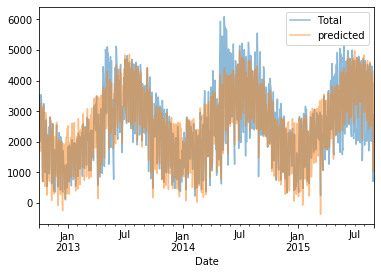

In [523]:
daily_raw[['Total', 'predicted']].plot(alpha=0.5);